In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math

## Setup

We consider a set of $N$ genomes and k-mers of length $k$.
All $N$ genomes are of the same length $L$, and assumed to have evolved from the
same ancestor genomes with Average Nucleotide Identity (ANI) of $\alpha$.
We use the Jukes-Cantor model of evolution, and assume that every base mutates
independently and uniformly at random with probability $1 - \alpha$

Let $G_{i,j}$ be the $k$-mer in genome $i$ starting at base $j$

Let $X_{i,j,m}$ be the indicator random variable that is $1$ iff the $k$-mer
in genome $i$ starting at base $j$ appears with multiplicity $m$.


In [2]:
N = 10 # number of genomes
L = 2000000 # length of the genomes 
p = 0.998 # ANI
k = 12 # length of the kmer

In [3]:
def generate_string(l):
    return ''.join(np.random.choice(['A', 'C', 'G', 'T'], l))

def mutate_string(S, p):
    chars = np.array(['A', 'C', 'G', 'T'])
    S_array = np.array(list(S))
    mutated_S = S_array.copy()
    
    mutation_mask = np.random.rand(len(S)) > p
    for i in range(len(S)):
        if mutation_mask[i]:
            available_chars = chars[chars != S_array[i]]
            mutated_S[i] = np.random.choice(available_chars)
    
    return ''.join(mutated_S)

def generate_strings(n, l, p):
    S = generate_string(l)
    mutated_strings = [mutate_string(S, p) for _ in range(n)]
    return S, mutated_strings

# Generate the strings
original_string, mutated_strings = generate_strings(N, L, p)

# print(f"Original string: {original_string}")
# print("Mutated strings:")
# for i, s in enumerate(mutated_strings):
#     print(f"{i+1}:\t{s}")

In [4]:
kmer_dict = {}
for s in mutated_strings:
    string_set = set()
    for idx in range(len(s)-k+1):
        string_set.add(s[idx:idx+k])

    for kmer in string_set:
        kmer_dict[kmer] = kmer_dict.get(kmer,0)+1


We make the following simplifying assumptions

- $k$-mers can only appear multiple times in the same region. This assumption is violated if $k$ is small and the length of the genome is sufficiently large

The probability that $G_{i,j}$ is mutated at exactly $a$ positions in the $k$-mer is 

$$
\begin{align*}
    \binom{k}{a} (1-\alpha)^{a} \alpha^{k-a}
\end{align*}
$$

Let us fix $j$, the base position, and $m$ the multiplicity. 
The probability that there exist exactly $m > 0$ genomes $i_1,i_2,\cdots,i_m$ 
such that $G_{i_1,j},G_{i_2,j},\cdots,G_{i_m,j}$ mutate in the exact same set of $a$ positions is:

$$
\begin{align*}
    \binom{k}{a} \cdot \binom{N}{m} \cdot \left ( (1-\alpha)^{a} \alpha^{k-a} \right )^m \cdot \left ( 1 - (1-\alpha)^{a} \alpha^{k-a} \right )^{N-m}
\end{align*}
$$

In [5]:
def mutation_probability_of_x_positions_in_kmer(k : int, x : int, alpha : float):
    return ((1 - alpha) ** x) * (alpha ** (k-x))

def genome_mutation_multiplicity_probability(m : int, N : int, k : int, x : int, alpha : float):
    mp = mutation_probability_of_x_positions_in_kmer(k,x,alpha)
    return (mp ** m) * ((1 - mp) ** (N - m))

def expected_kmer_multiplicity(m : int, N : int, k : int, alpha : float):
    return sum(math.comb(k,x) * math.comb(N,m) * genome_mutation_multiplicity_probability(m,N,k,x,alpha) for x in range(0,k+1))


2470642.585198434


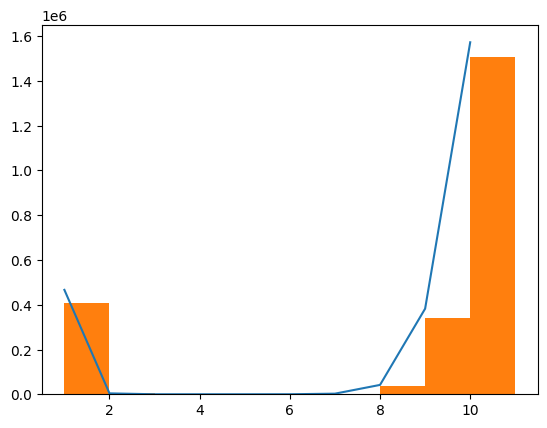

In [6]:
vals = list(kmer_dict.values())
x = list(range(1,N+1))
y=[expected_kmer_multiplicity(i,N,k,p) * L for i in range(1,N+1)]
print(sum(y))

fig, ax = plt.subplots()
ax.plot(x,y)
ax.hist(vals, bins=range(min(vals),max(vals)+2))
plt.show()